In [85]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn import multiclass
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from scipy import stats

In [86]:
from tensorflow.keras import utils
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [87]:
# Using methods from other notebook!
%run 'preprocessing_functions.ipynb'

In [88]:
# Loading fer2013 dataset, it's already split in train and test data!
train_data, train_labels = load_data('datasets/FER2013/train')
test_data, test_labels = load_data('datasets/FER2013/test')

In [90]:
# As we see, train dataset consists of 28709 images of 48 x 48 px!
train_data.shape

(28709, 48, 48)

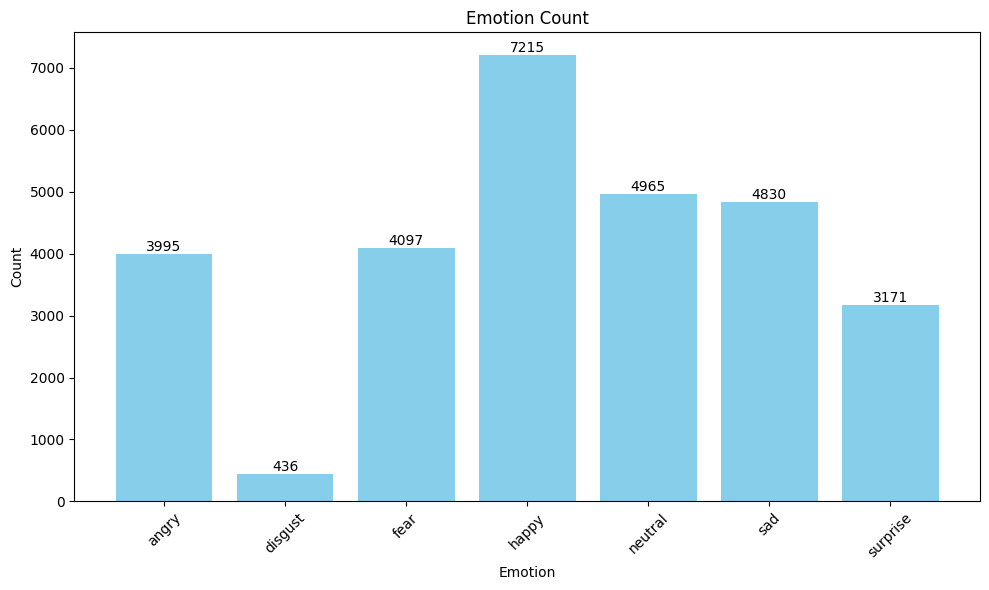

In [91]:
plot_count(train_data, train_labels)

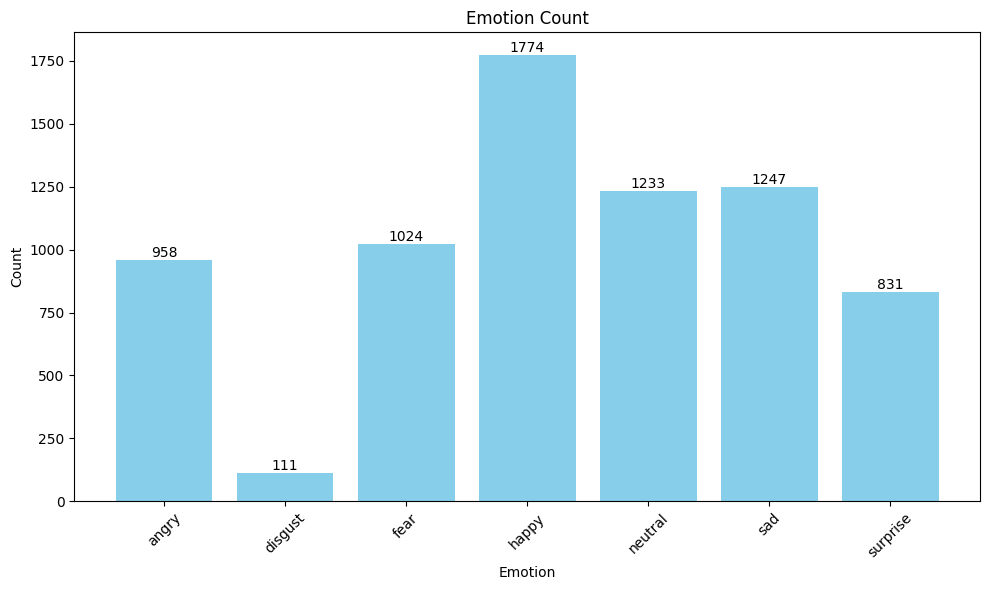

In [92]:
plot_count(test_data, test_labels)

In [93]:
# Here, we'll use different approach to unbalanced data. Because disgust is much smaller class than the others, 
# we'll make more models, and use voting when we testing

In [94]:
train_data, train_labels = add_mirrored_images_upto(train_data, train_labels, upto=436*11, include=["angry", "fear", "surprise"])

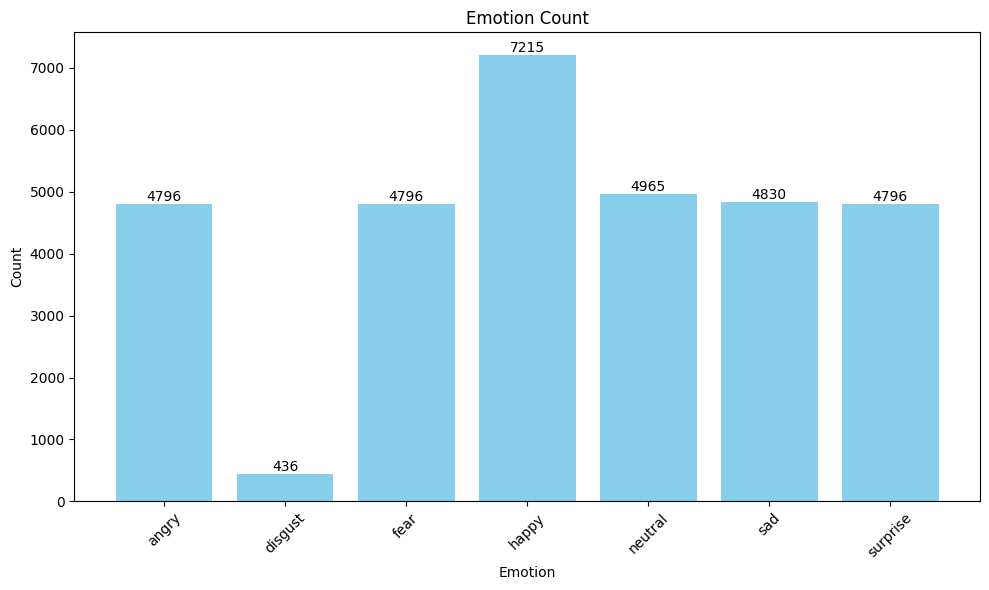

In [95]:
plot_count(train_data, train_labels)

In [96]:
seed = 12
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "happy", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "neutral", 436*11, seed)
train_data, train_labels = random_delete_upto_2(train_data, train_labels, "sad", 436*11, seed)

In [101]:
# Just checking whether we work with corect labels!
set_labels=set()
set_test_labels=set()
for label in train_labels:
    #print(label, end='')
    if label not in set_labels:
        set_labels.add(label)
        print(label, end=' ')
print('\n------------------------------------------') 
for label in test_labels:
    if label not in set_test_labels:
        set_test_labels.add(label)
        print(label, end=' ')

angry disgust fear happy neutral surprise sad 
------------------------------------------
angry surprise neutral disgust happy fear sad 

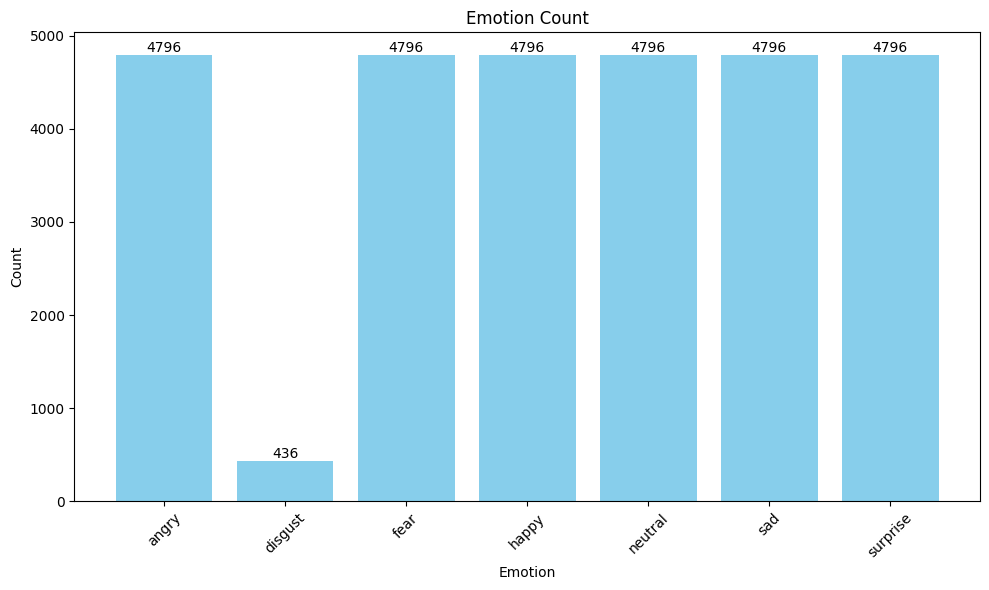

In [41]:
plot_count(train_data, train_labels)

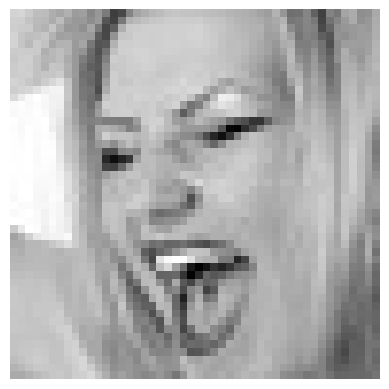

angry


In [42]:
# Just to see with what kind of images we are dealing with!
plot_image(train_data[0], train_labels[0])

In [43]:
# Checking the shape of train data and setting global variables which we will use later!

print(train_data[0].shape)
print(train_labels[0])

ROWS=48
COLS=48
NUM_OF_CHANNELS=1
NUM_OF_CLASSES=7
K.image_data_format()

(48, 48)
angry


'channels_last'

In [44]:
# Changing the dimensions of our data in order to fit in our neural nets!

#train_data.shape
train_data=np.array(train_data)
test_data=np.array(test_data)
train_data = train_data.reshape(train_data.shape[0], ROWS, COLS, 1)
test_data = test_data.reshape(test_data.shape[0], ROWS, COLS, 1)
input_shape = (ROWS, COLS, 1)

In [45]:
# Checking the size of our data again!

print(train_data.shape)
print(test_data.shape)

(29212, 48, 48, 1)
(7178, 48, 48, 1)


In [46]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


In [47]:
# Maybe this is too large and complex model for our dataset!

alexnet_model = Sequential([
    Conv2D(96, kernel_size=(11,11), strides=(1,1), padding='same', activation='relu', input_shape=(ROWS, COLS, NUM_OF_CHANNELS)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    #Dense(NUM_OF_CLASSES, activation='softmax')
    Dense(NUM_OF_CLASSES, activation='softmax')
])


In [48]:
# Just to see again the content of our network, but better represented!
alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 96)        11712     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 23, 23, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 384)      

In [49]:
# Checking the size of our data again!
print(test_data.shape)
print(train_data.shape)

(7178, 48, 48, 1)
(29212, 48, 48, 1)


In [50]:
# Decreasing the scale of our train data! It will now be within [0, 1] interval!
train_data=train_data.astype('float32')
train_data/=255

In [51]:
# Decreasing the scale of our test data! It will now be within [0, 1] interval!
test_data=test_data.astype('float32')
test_data/=255

In [52]:
# Here we are going to convert our train labels into float numbers!

EPOCHS = 20
BATCH_SIZE = 128

train_data=np.array(train_data)
train_labels=np.array(train_labels)
train_labels_new=[]
for label in train_labels:
    if label=='angry':
        train_labels_new.append(0)
    if label=='disgust':
        train_labels_new.append(1)
    if label=='fear':
        train_labels_new.append(2)
    if label=='happy':
        train_labels_new.append(3)
    if label=='neutral':
        train_labels_new.append(4)
    if label=='sad':
        train_labels_new.append(5)
    if label=='surprise':
        train_labels_new.append(6)
train_labels_new=np.array(train_labels_new)
print(train_labels_new.shape)
train_labels=train_labels_new


(29212,)


In [53]:
# Here we are going to convert our test labels into float numbers!

test_data=np.array(test_data)
test_labels=np.array(test_labels)
test_labels_new=[]
for label in test_labels:
    if label=='angry':
        test_labels_new.append(0)
    if label=='disgust':
        test_labels_new.append(1)
    if label=='fear':
        test_labels_new.append(2)
    if label=='happy':
        test_labels_new.append(3)
    if label=='neutral':
        test_labels_new.append(4)
    if label=='sad':
        test_labels_new.append(5)
    if label=='surprise':
        test_labels_new.append(6)
test_labels_new=np.array(test_labels_new)
print(test_labels_new.shape)
test_labels=test_labels_new

(7178,)


In [54]:
# Checking whether everything was okay with converting train and test labels!

print(train_labels[0])
print(train_data.shape)
set_labels=set()
for label in train_labels:
    #print(y)
    if label not in set_labels:
        set_labels.add(label)
        print(label, end=' ')

0
(29212, 48, 48, 1)
0 1 2 3 4 6 5 

In [55]:
# Converting train and test labels from float values to coresponding vectors!
number_of_classes = 7

train_labels=utils.to_categorical(train_labels, number_of_classes)
test_labels=utils.to_categorical(test_labels, number_of_classes)

In [56]:
# This is how they look now!

print(train_labels[0])
print(test_labels[0])

[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]


In [57]:
# Compiling alexnet neural network!
alexnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [33]:
# Now, we can let our model to train!
history = alexnet_model.fit(train_data, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/20
183/183 [==============================] - 374s 2s/step - loss: 1.7007 - accuracy: 0.2071 - val_loss: 7.2420 - val_accuracy: 0.0000e+00
Epoch 2/20
183/183 [==============================] - 370s 2s/step - loss: 1.6715 - accuracy: 0.2048 - val_loss: 7.8704 - val_accuracy: 0.0000e+00
Epoch 3/20
183/183 [==============================] - 367s 2s/step - loss: 1.6714 - accuracy: 0.2012 - val_loss: 7.1714 - val_accuracy: 0.0000e+00
Epoch 4/20
183/183 [==============================] - 345s 2s/step - loss: 1.6710 - accuracy: 0.2066 - val_loss: 7.6678 - val_accuracy: 0.0000e+00
Epoch 5/20
183/183 [==============================] - 343s 2s/step - loss: 1.6707 - accuracy: 0.2010 - val_loss: 7.3514 - val_accuracy: 0.0000e+00
Epoch 6/20
183/183 [==============================] - 264s 1s/step - loss: 1.6707 - accuracy: 0.2047 - val_loss: 7.8359 - val_accuracy: 0.0000e+00
Epoch 7/20
183/183 [==============================] - 252s 1s/step - loss: 1.6703 - accuracy: 0.2043 - val_loss: 8.243

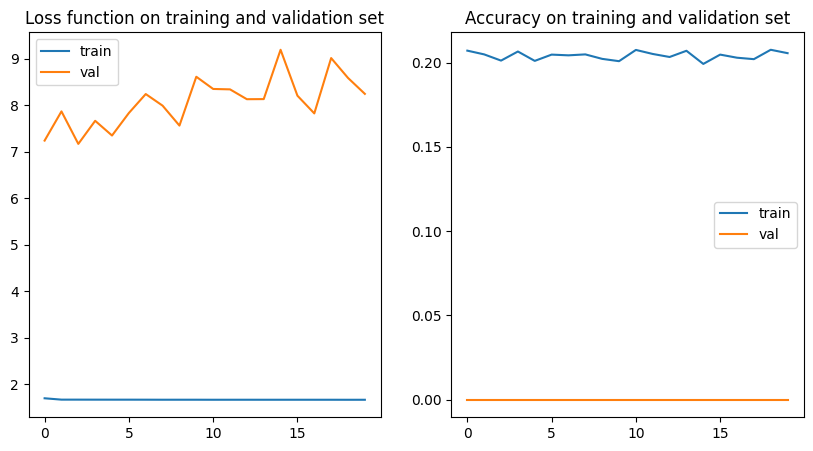

In [35]:
# After training our model, we will show the values of loss function and accuracy function
# on training and validation set throught epochs!

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Loss function on training and validation set')
plt.plot(history.epoch, history.history['loss'], label='train')
plt.plot(history.epoch, history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy on training and validation set')
plt.plot(history.epoch, history.history['accuracy'], label='train')
plt.plot(history.epoch, history.history['val_accuracy'], label='val')
plt.legend(loc='best')

# In case you would like to save a diagram picture, uncomment a line bellow!
plt.savefig('the_first_results.png')

plt.show()

In [36]:
# Here we will chose model which we would like to evaluate!
model = alexnet_model

In [37]:
# Here we will evaluate the model of our interest on test data!

score=model.evaluate(test_data, test_labels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

225/225 [==============================] - 23s 102ms/step - loss: 3.0544 - accuracy: 0.2471
Test loss: 3.0544402599334717
Test accuracy: 0.24714405834674835


In [38]:
# Here we will evaluate the model of our interest on training data!
score=model.evaluate(train_data, train_labels)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

913/913 [==============================] - 94s 103ms/step - loss: 2.9849 - accuracy: 0.1642
Training loss: 2.984938144683838
Training accuracy: 0.16417910158634186


In [39]:
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
# Below we have a better try of creating confusion matrix and classification report!
# You should look below and ignore couple of above cells!

In [41]:
from sklearn.metrics import confusion_matrix, classification_report

In [42]:
# Trying to create a confusion matrix!

X_test=test_data
y_test=test_labels
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1) 

225/225 [==============================] - 23s 102ms/step


In [44]:
print(y_predicted_classes.shape)
y_test_classes = np.argmax(y_test, axis = 1) 
print(y_test_classes.shape)

(7178,)
(7178,)


In [45]:
# Creating and printing the confusion matrix of our model!

confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)
print(confusion_matrix)

[[   0    0    0  958    0    0    0]
 [   0    0    0  111    0    0    0]
 [   0    0    0 1024    0    0    0]
 [   0    0    0 1774    0    0    0]
 [   0    0    0 1233    0    0    0]
 [   0    0    0 1247    0    0    0]
 [   0    0    0  831    0    0    0]]


In [51]:
#Creating and displaying classification report about our model!

report = classification_report(y_test_classes, y_predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.25      1.00      0.40      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# We will now try to test different model!

In [62]:
# Here you can see a way smaller and simplier model than alexnet model. It will have way better results with it! 
model = Sequential([
    Input(shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(number_of_classes, activation='softmax')
])

In [63]:
# Presenting the summary of our new model!
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_18 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 36864)             0         
                                                                 
 dense_11 (Dense)            (None, 128)               4718720   
                                                      

In [64]:
# Compiling our model!
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [65]:
# We will use different notation here, just to make our code more readable!

batch_size = 128
epochs = 20

X_train=train_data
y_train=train_labels
X_test=test_data
y_test=test_labels

In [70]:
# We will now let our model to train!
# This cell has been executed a couple of times!
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/20
183/183 [==============================] - 34s 185ms/step - loss: 0.2780 - accuracy: 0.8845 - val_loss: 23.9050 - val_accuracy: 0.1309
Epoch 2/20
183/183 [==============================] - 34s 184ms/step - loss: 0.2782 - accuracy: 0.8866 - val_loss: 24.5281 - val_accuracy: 0.1280
Epoch 3/20
183/183 [==============================] - 34s 184ms/step - loss: 0.2789 - accuracy: 0.8879 - val_loss: 24.2285 - val_accuracy: 0.1227
Epoch 4/20
183/183 [==============================] - 34s 184ms/step - loss: 0.2744 - accuracy: 0.8849 - val_loss: 23.7432 - val_accuracy: 0.1285
Epoch 5/20
183/183 [==============================] - 34s 184ms/step - loss: 0.2722 - accuracy: 0.8883 - val_loss: 23.2064 - val_accuracy: 0.1290
Epoch 6/20
183/183 [==============================] - 31s 167ms/step - loss: 0.2635 - accuracy: 0.8929 - val_loss: 25.0857 - val_accuracy: 0.1294
Epoch 7/20
183/183 [==============================] - 26s 142ms/step - loss: 0.2606 - accuracy: 0.8932 - val_loss: 25.9760 -

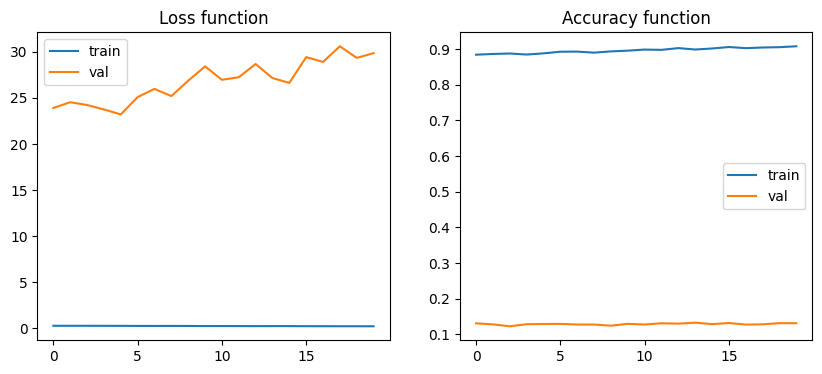

In [72]:
# After training our model, we will show the values of loss function and accuracy function
# on training and validation set throught epochs!

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss function')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy function')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

plt.show()

In [73]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 8.22528076171875
Test accuracy: 0.4915018081665039


In [74]:
from sklearn.metrics import confusion_matrix, classification_report

In [75]:
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1) 

225/225 [==============================] - 2s 10ms/step


In [76]:
# Just checking something!
print(y_predicted[0])
print(y_test[0])
print(np.argmax(y_predicted[0]))
print(np.argmax(y_test[0]))

[1.3335632e-01 7.5117601e-09 4.0168240e-04 8.6088121e-01 5.3592087e-03
 1.7798547e-14 1.6139520e-06]
[1. 0. 0. 0. 0. 0. 0.]
3
0


In [77]:
print(y_predicted_classes.shape)
y_test_classes = np.argmax(y_test, axis = 1) 
print(y_test_classes.shape)

(7178,)
(7178,)


In [78]:
# Creating and printing the confusion matrix of our model!

confusion_matrix= confusion_matrix(y_test_classes, y_predicted_classes)
print(confusion_matrix)

[[ 539    2  163   73  133    0   48]
 [  40   40   13    7    7    0    4]
 [ 211    1  499   73  141    0   99]
 [ 204    0  145 1209  165    0   51]
 [ 230    1  188  118  652    0   44]
 [ 382    3  324  156  336    0   46]
 [  58    0  109   39   36    0  589]]


In [79]:
#Creating and displaying classification report about our model!

report = classification_report(y_test_classes, y_predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.32      0.56      0.41       958
           1       0.85      0.36      0.51       111
           2       0.35      0.49      0.40      1024
           3       0.72      0.68      0.70      1774
           4       0.44      0.53      0.48      1233
           5       0.00      0.00      0.00      1247
           6       0.67      0.71      0.69       831

    accuracy                           0.49      7178
   macro avg       0.48      0.48      0.46      7178
weighted avg       0.44      0.49      0.46      7178



/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ptesic@syrmia.com/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.autograd import Variable

#import transforms as transforms
from skimage import io
from skimage.transform import resize
#from models import *

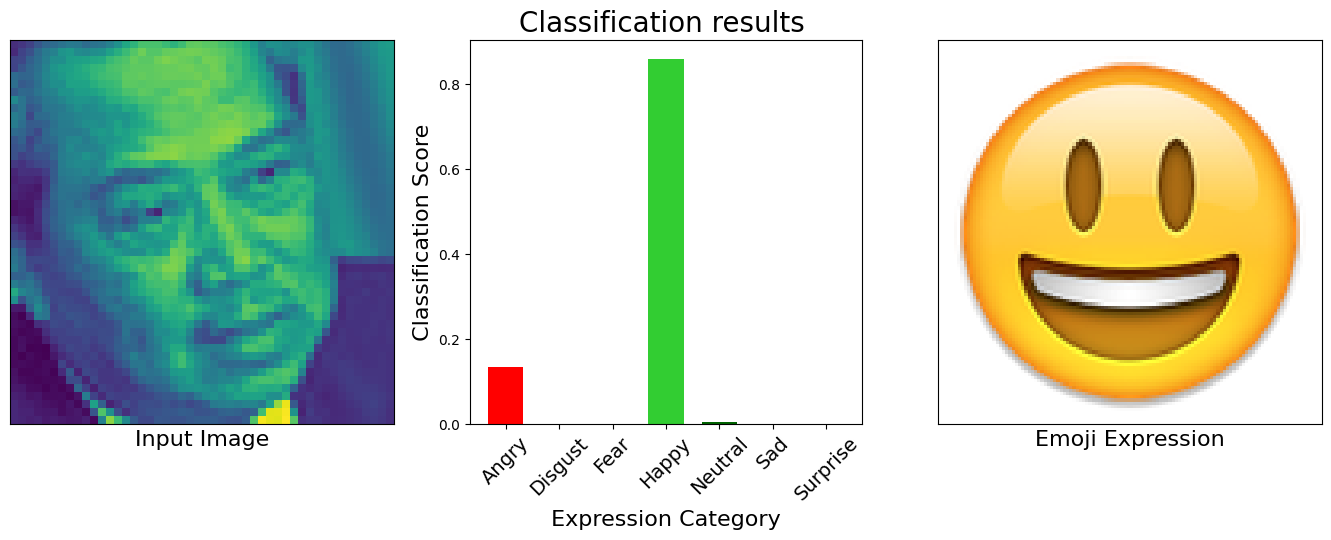

The Expression is Happy!


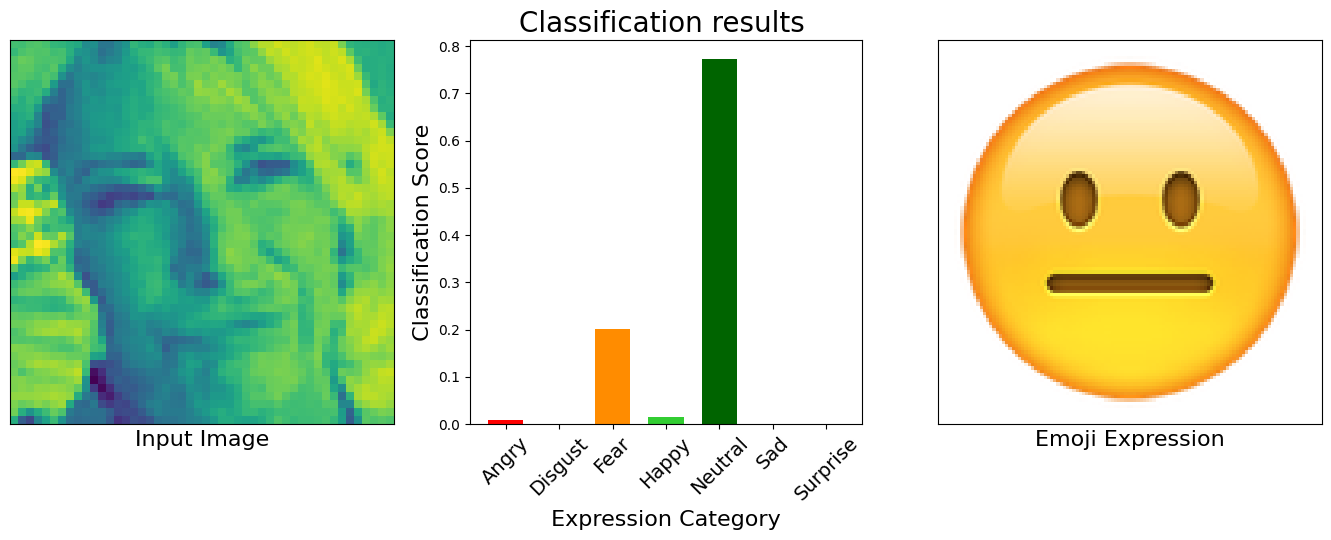

The Expression is Neutral!


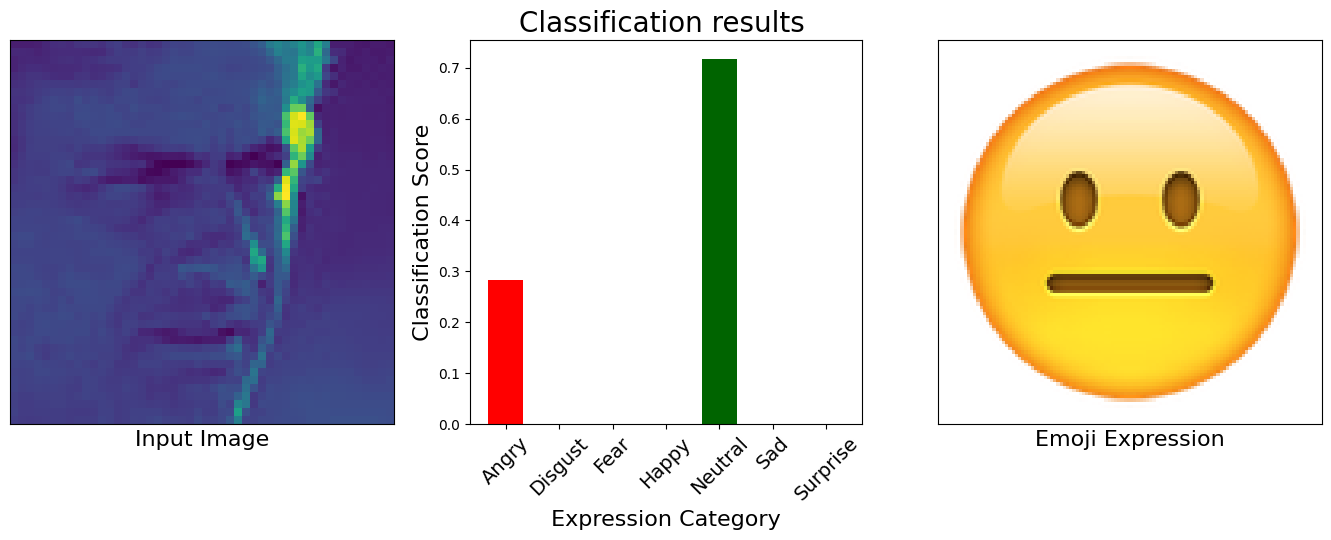

The Expression is Neutral!


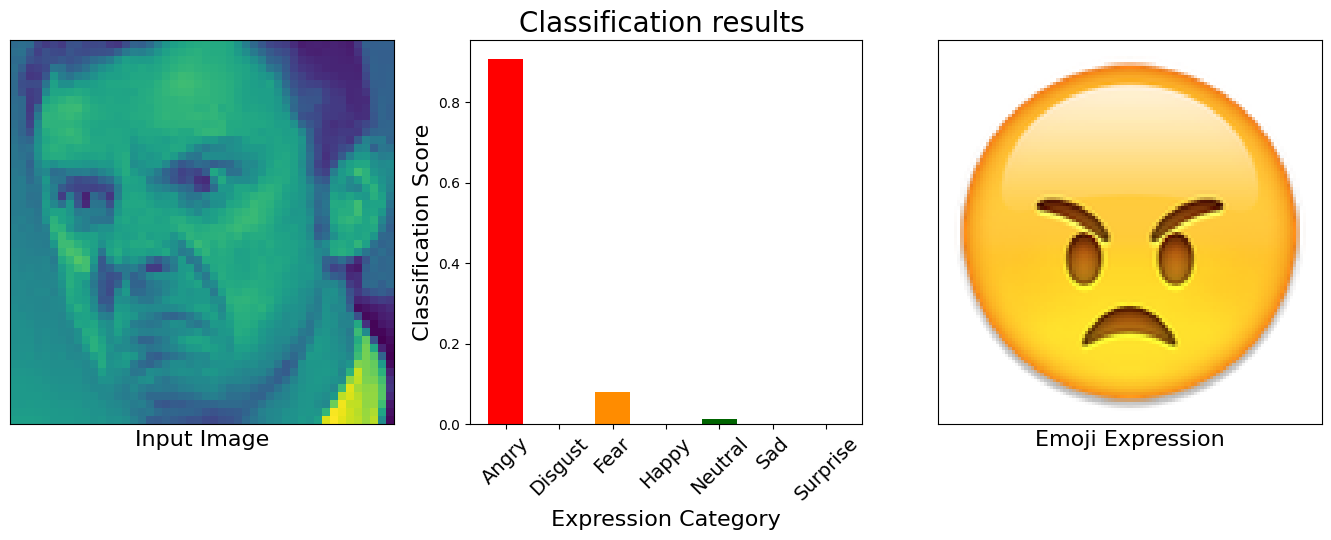

The Expression is Angry!


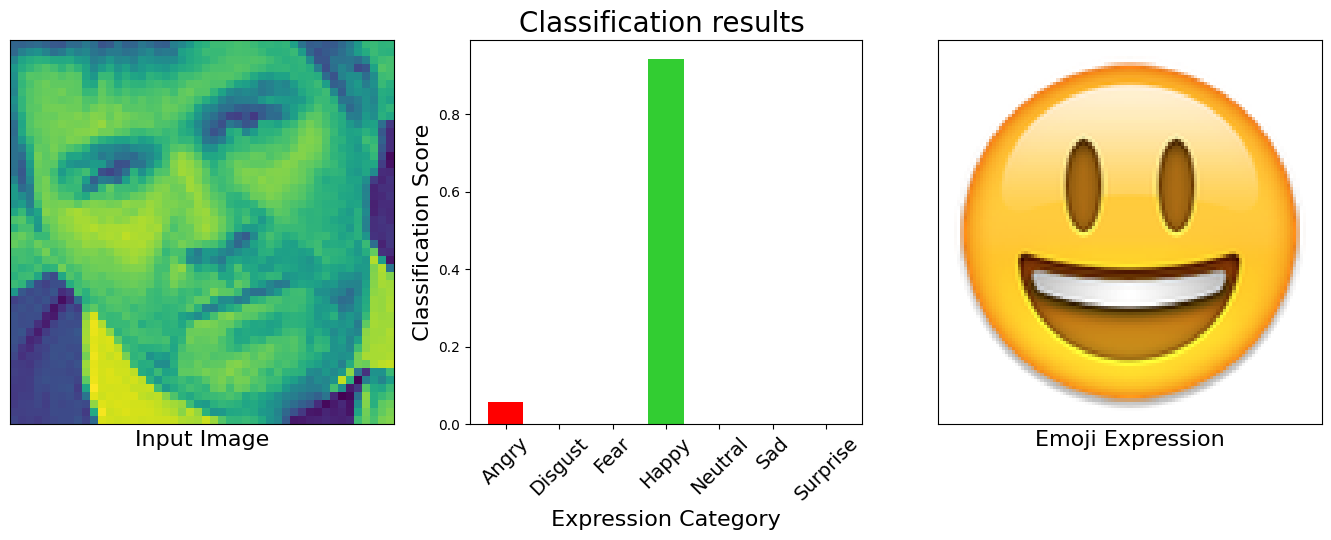

The Expression is Happy!


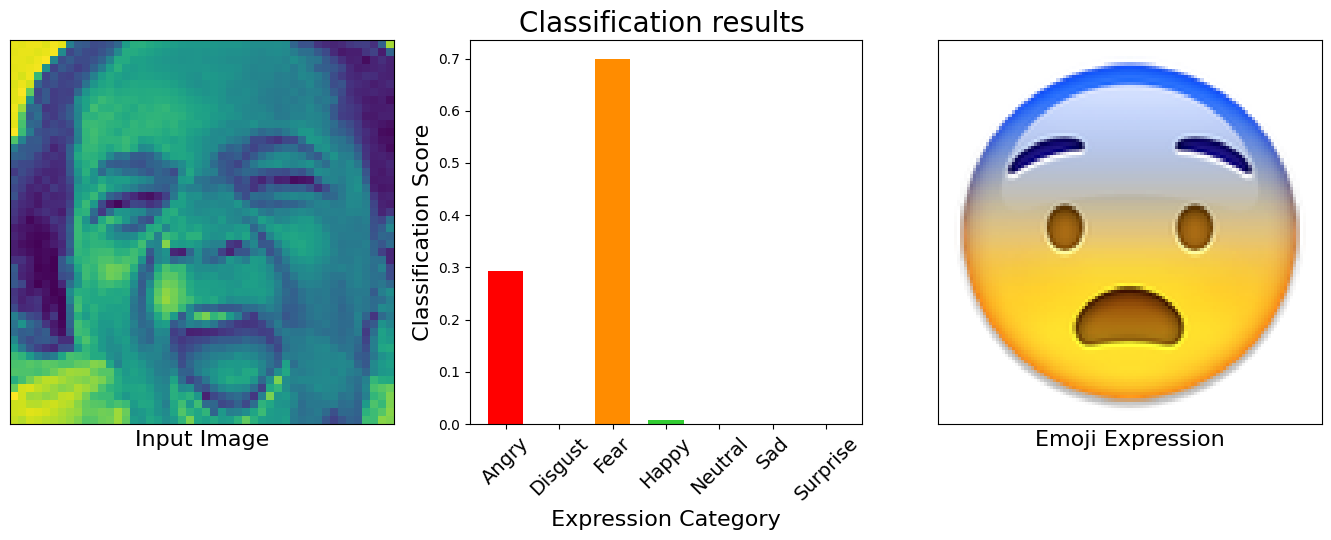

The Expression is Fear!


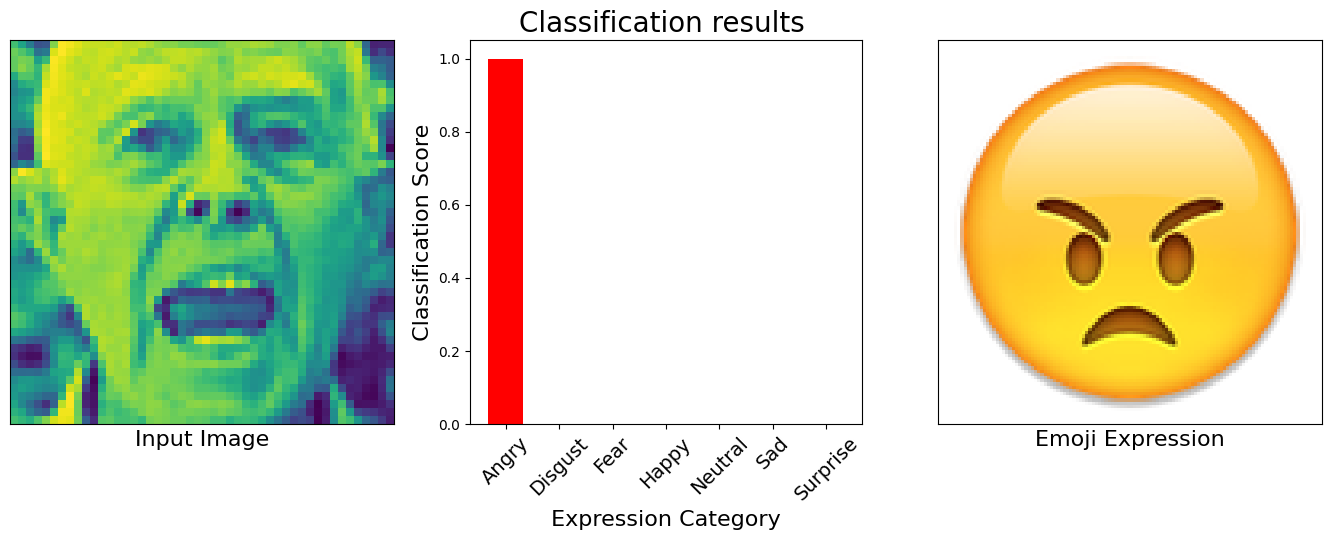

The Expression is Angry!


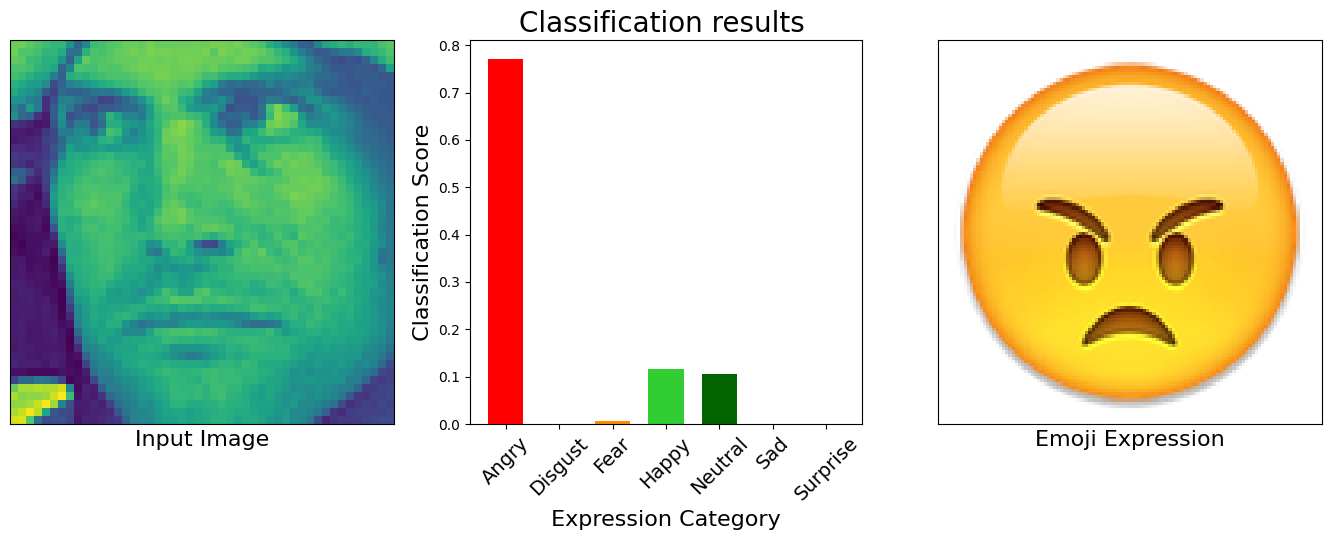

The Expression is Angry!


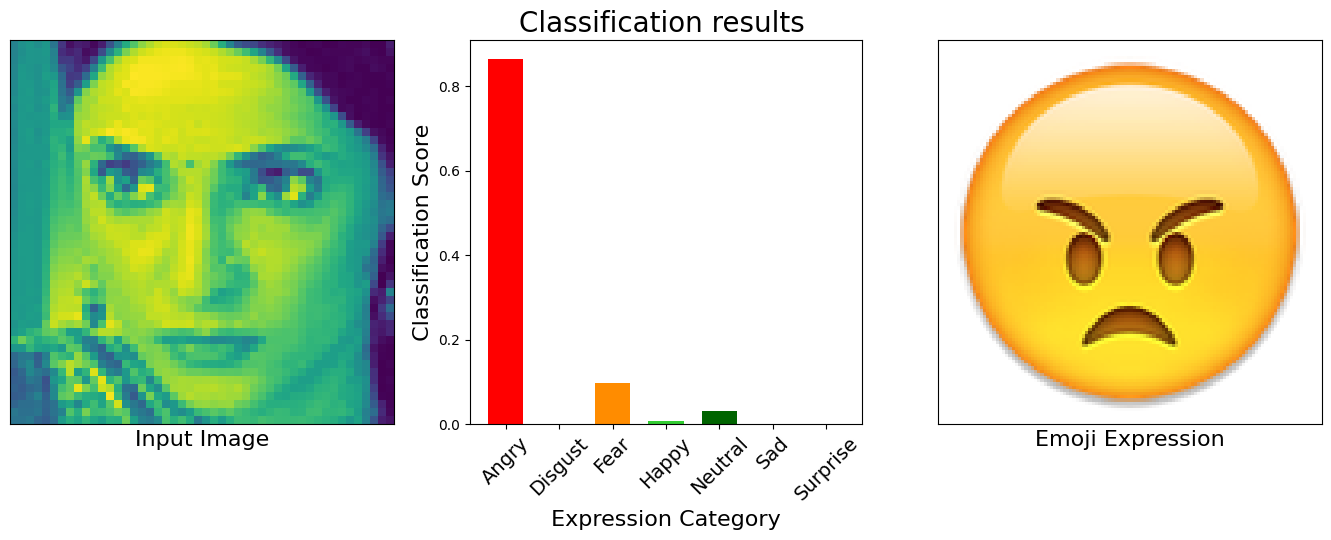

The Expression is Angry!


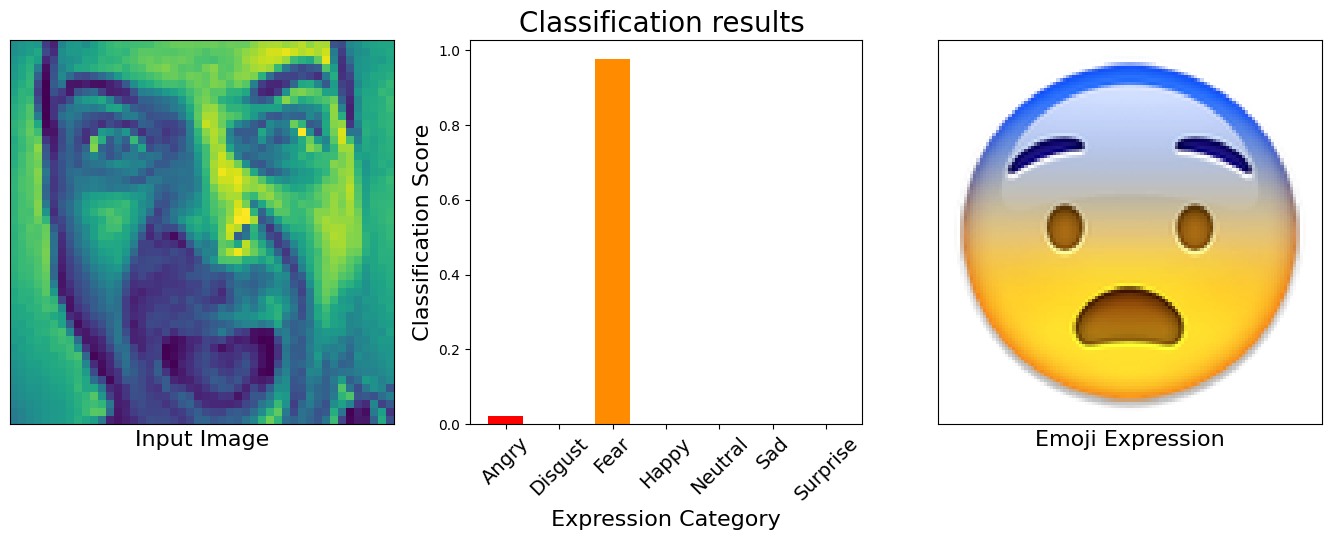

The Expression is Fear!


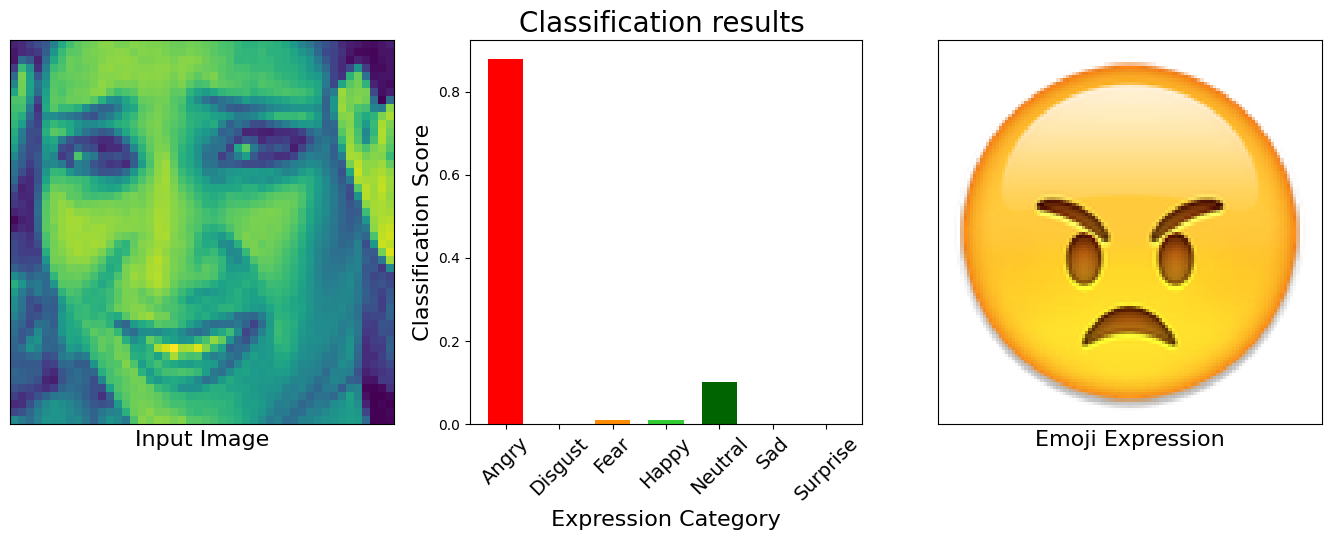

The Expression is Angry!


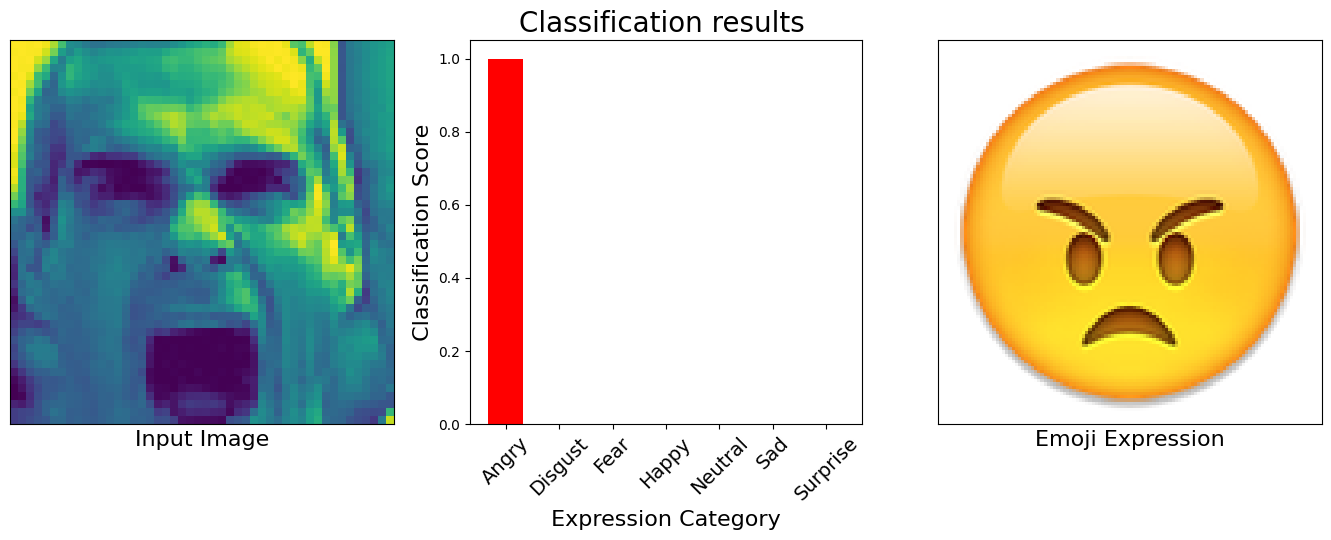

The Expression is Angry!


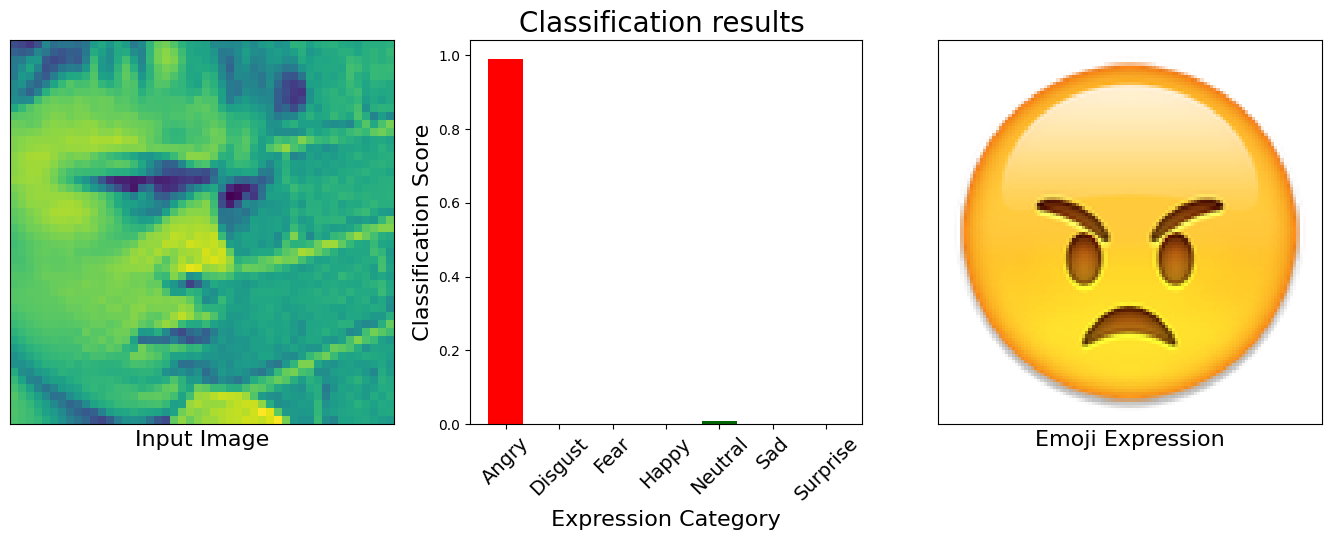

The Expression is Angry!


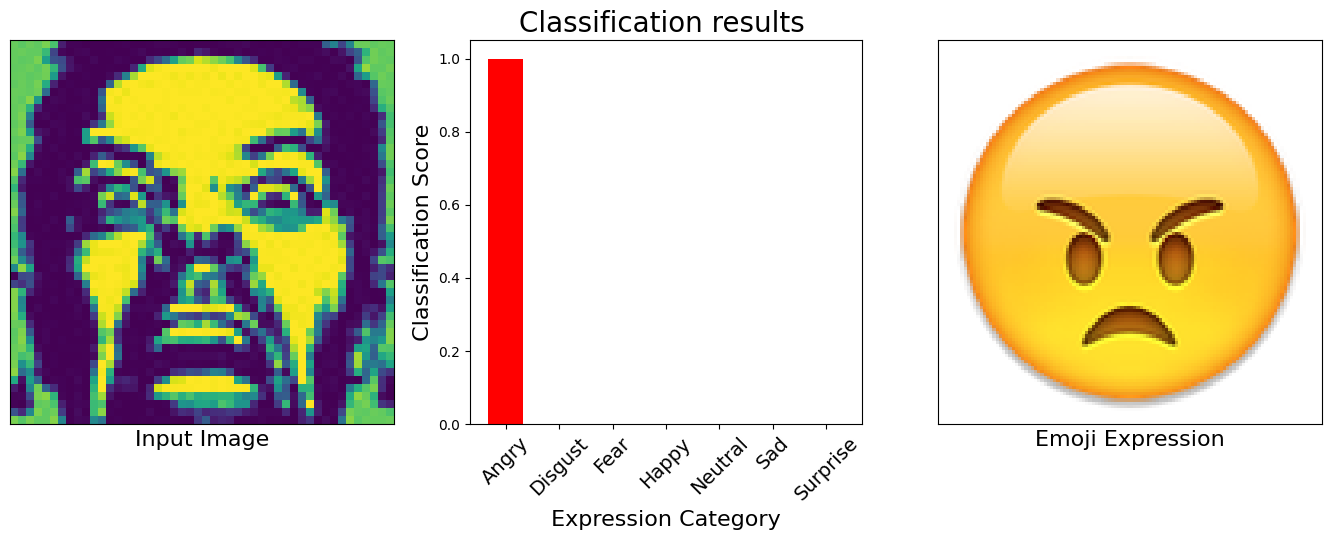

The Expression is Angry!


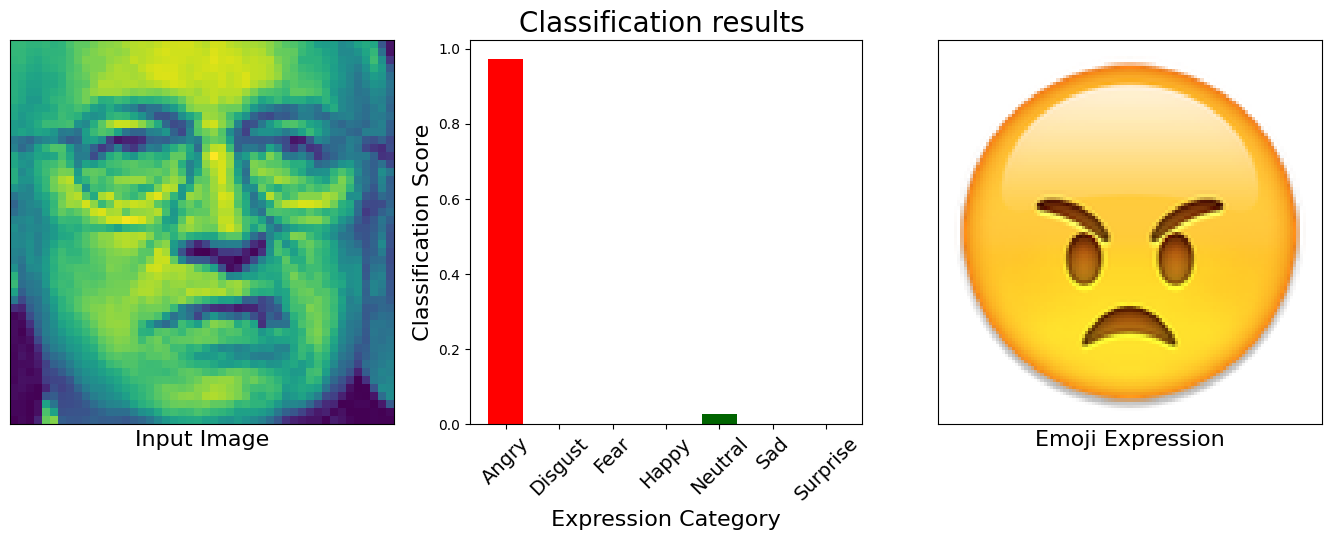

The Expression is Angry!


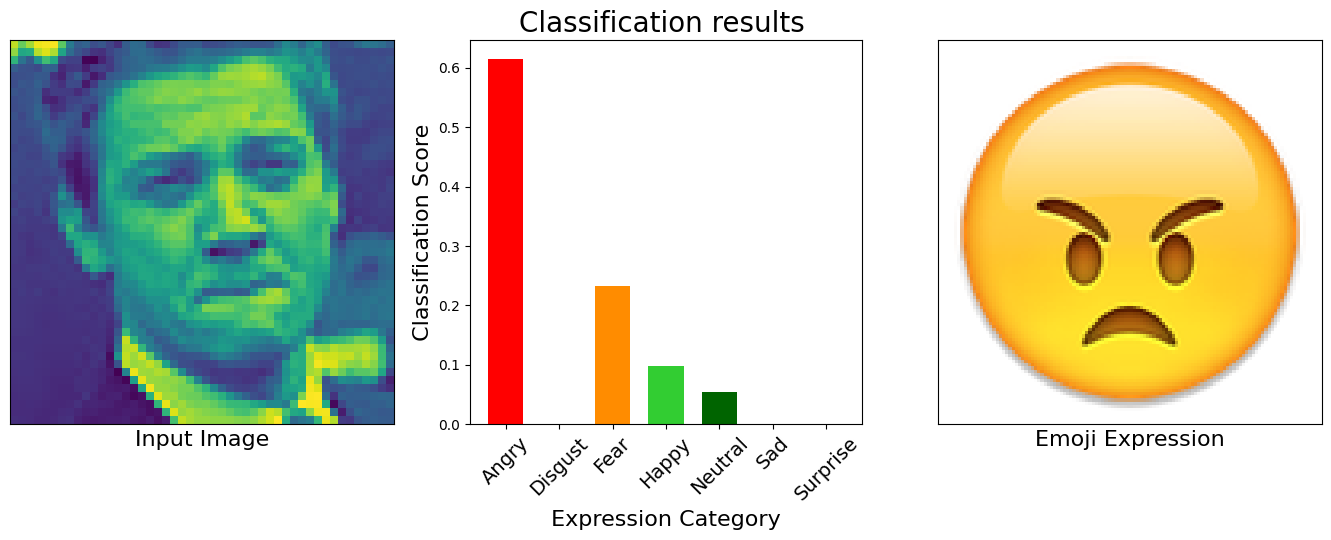

The Expression is Angry!


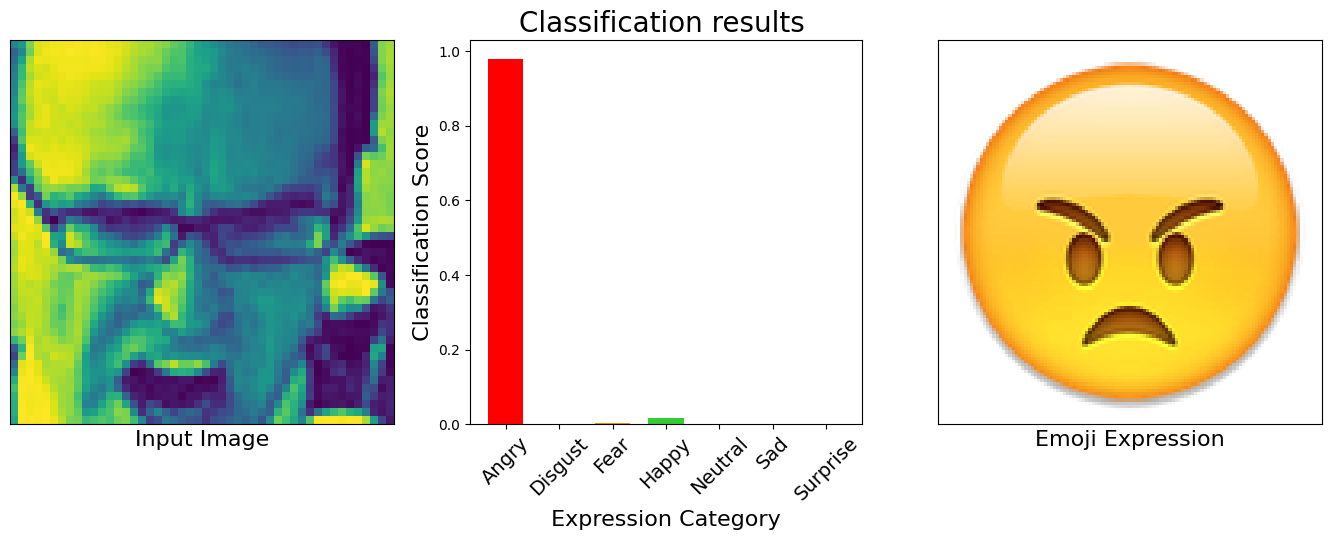

The Expression is Angry!


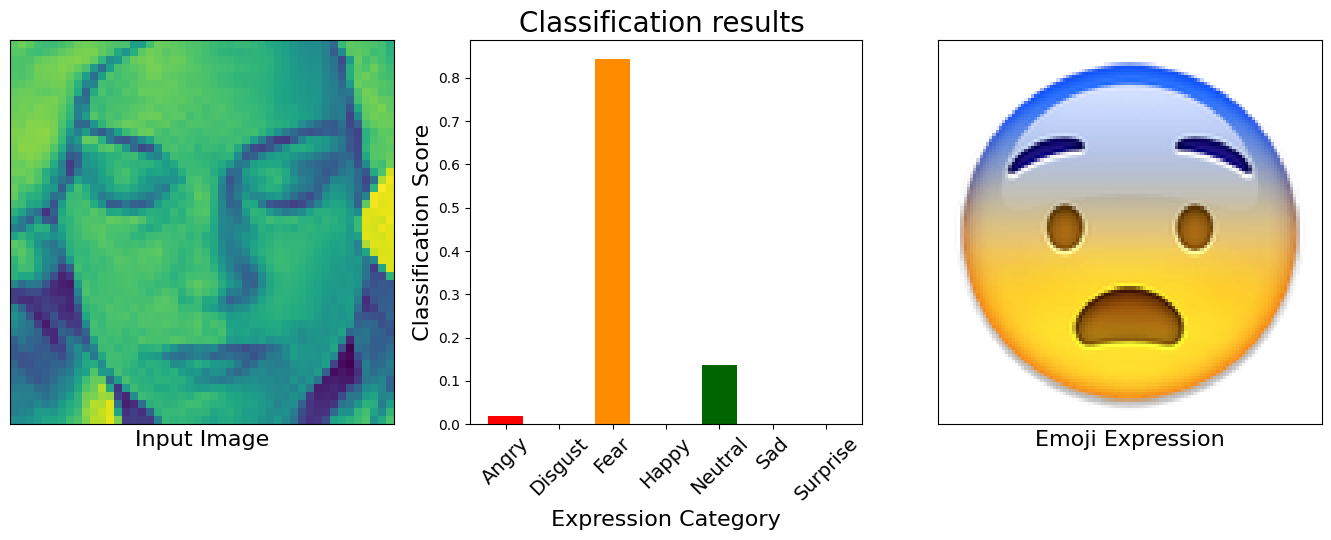

The Expression is Fear!


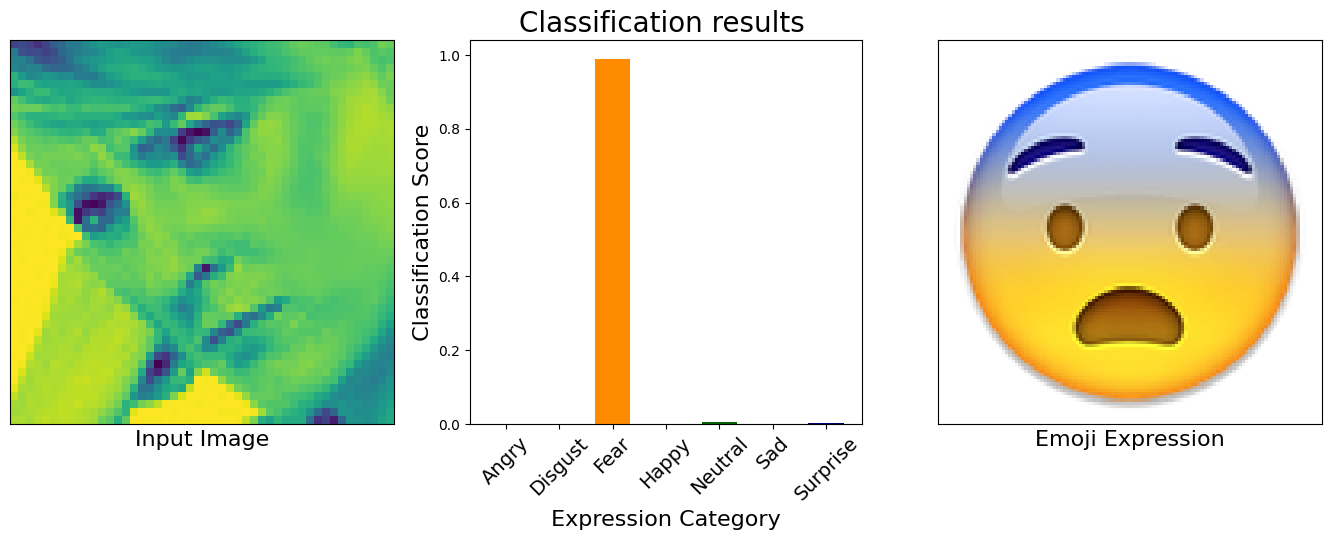

The Expression is Fear!


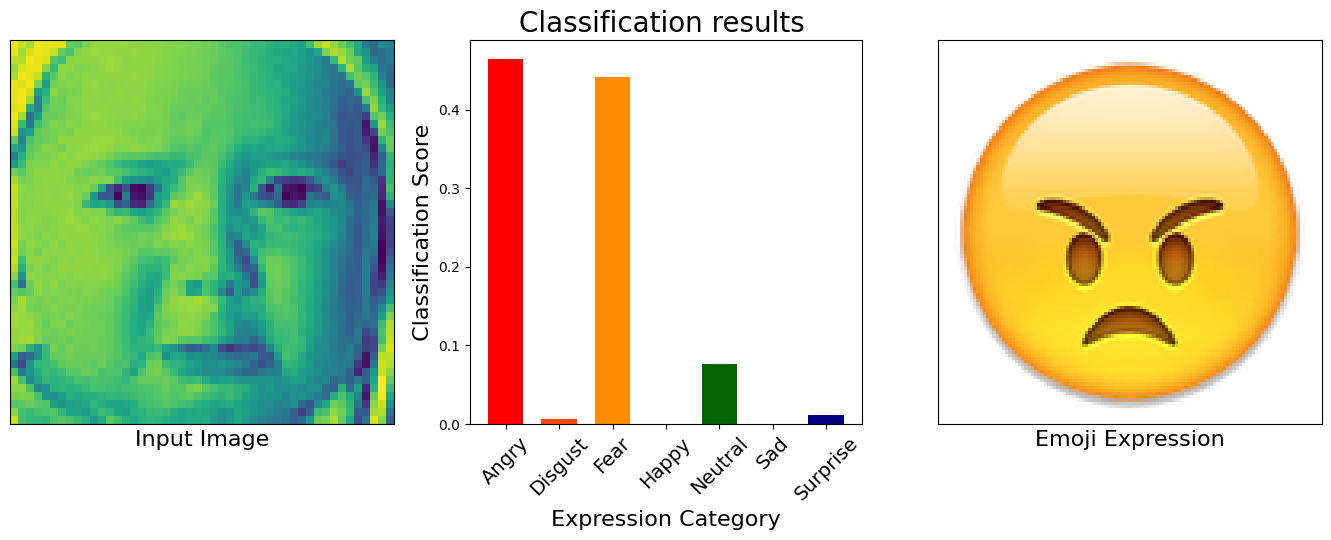

The Expression is Angry!


In [82]:
# Representing the results of our model hopefully in a more funny way!

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral' ,'Sad', 'Surprise']


for j in range(20):
    plt.rcParams['figure.figsize'] = (13.5,5.5)
    axes=plt.subplot(1, 3, 1)
    #plt.imshow(raw_img)
    plt.imshow(X_test[j])
    plt.xlabel('Input Image', fontsize=16)
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout()


    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.95, top=0.9, hspace=0.02, wspace=0.3)

    plt.subplot(1, 3, 2)
    ind = 0.1+0.6*np.arange(len(class_names))    # the x locations for the groups
    width = 0.4       # the width of the bars: can also be len(x) sequence
    color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']
    for i in range(len(class_names)):
        plt.bar(ind[i], y_predicted[j][i], width, color=color_list[i])
    plt.title("Classification results ",fontsize=20)
    plt.xlabel(" Expression Category ",fontsize=16)
    plt.ylabel(" Classification Score ",fontsize=16)
    plt.xticks(ind, class_names, rotation=45, fontsize=14)

    axes=plt.subplot(1, 3, 3)
    emojis_img = io.imread('datasets/images/emojis/%s.png' % str(class_names[int(np.argmax(y_predicted[j]))]))
    plt.imshow(emojis_img)
    plt.xlabel('Emoji Expression', fontsize=16)
    axes.set_xticks([])
    axes.set_yticks([])
    plt.tight_layout()
    # show emojis

    plt.show()
    #plt.savefig(os.path.join('images/results/l.png'))
    plt.close()

    print("The Expression is %s!" %str(class_names[int(np.argmax(y_predicted[j]))]))